In [144]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize, WordNetLemmatizer, PorterStemmer, wordnet

In [145]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [146]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar
import seaborn as sns

def bootstrap(model_name, model, Xtrain, ytrain,Xtest, ytest):
    boots = []
    split_size = int(Xtrain.shape[0]*0.75)
    for i in tqdm(range(1000)):
        Xb, yb = resample(Xtrain, ytrain) #bootsrapping random resample
        Xb_train = Xb[:split_size] #train data
        yb_train = yb[:split_size]
        Xb_test = Xb[split_size:] # validation data
        yb_test = yb[split_size:]
        model.fit(Xb_train, yb_train) #fit on the train data
        score = model.score(Xb_test, yb_test) # score on the val data
        boots.append(score) # save the score
    boots.sort() # sort scores from best to worst - required for my confidence interval levels
    ci80 = boots[100:-100]
    ci90 = boots[50:-50]
    ci99 = boots[5:-5]
    sns.displot(boots, bins=20, kde=True, )
    model_score = model.score(Xtest,ytest)
    plt.axvline(x=model_score, color = 'black', linestyle = '--')
    plt.text(s = 'test', x=model_score, y = 170, color = 'black')
    plt.axvline(x=ci80[0], color = 'red', linestyle = '--')
    plt.axvline(x=ci80[-1], color = 'red', linestyle = '--')
    plt.axvline(x=ci90[0], color = 'darkorange', linestyle = '--')
    plt.axvline(x=ci90[-1], color = 'darkorange', linestyle = '--')
    plt.axvline(x=ci99[0], color = 'gold', linestyle = '--')
    plt.axvline(x=ci99[-1], color = 'gold', linestyle = '--')
    plt.text(s = '80%', x=ci80[0], y = 130, color = 'red')
    plt.text(s = '90%', x=ci90[0], y = 140, color = 'darkorange')
    plt.text(s = '99%', x=ci99[0], y = 150, color = 'gold')
    plt.text(s = '80%', x=ci80[-1], y = 130, color = 'red')
    plt.text(s = '90%', x=ci90[-1], y = 140, color = 'darkorange')
    plt.text(s = '99%', x=ci99[-1], y = 150, color = 'gold')
    plt.title(f'distribution of 1000 bootstrapped {model_name} models, plus CI')
    plt.figure(figsize=(15,8))
    plt.show()
    None

In [147]:
def trained_model(Xtrain,ytrain):
    m = MultinomialNB()
    m.fit(Xtrain,ytrain)
    print('Score on train data: ', m.score(Xtrain,ytrain))
    return m

In [148]:
### Vectorizer:

class Vectorizer:
    def __init__(self, **kwargs):
        self.countvectorizer = CountVectorizer(**kwargs)
    def __call__(self,intrain,intest):
        Xtrain = self.countvectorizer.fit_transform(intrain)
        Xtest = self.countvectorizer.transform(intest)
        return Xtrain, Xtest


In [149]:
### Tag translator:

# def get_wordnet_pos(treebank_tag):
#   if treebank_tag.startswith('a'):
#     return wordnet.ADJ
#   elif treebank_tag.startswith('v'):
#     return wordnet.VERB
#   elif treebank_tag.startswith('n'):
#     return wordnet.NOUN
#   elif treebank_tag.startswith('r'):
#     return wordnet.ADV
#   else:
#     return wordnet.NOUN

### New tag translator:

def get_pos(tag):
  if tag.startswith('a'):
    return 'a'
  elif tag.startswith('v'):
    return 'v'
  elif tag.startswith('n'):
    return 'n'
  elif tag.startswith('r'):
    return 'r'
  else:
    return 'n'

In [150]:
### Tokenizers

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_pos(tag)) \
                for word, tag in words_and_tags]

class StemTokenizer:
    def __init__(self):
        self.stemmer = PorterStemmer()
    def __call__(self,doc):
        tokens = word_tokenize(doc)
        return [self.stemmer.stem(token) for token in tokens]

class simpleTokenizer:
    def __init__(self):
        pass
    def __call__(self,doc):
        return doc.split()


In [151]:
df = pd.read_csv('data/bbc/bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [152]:
labels = df.labels
inputs = df.text

<AxesSubplot:>

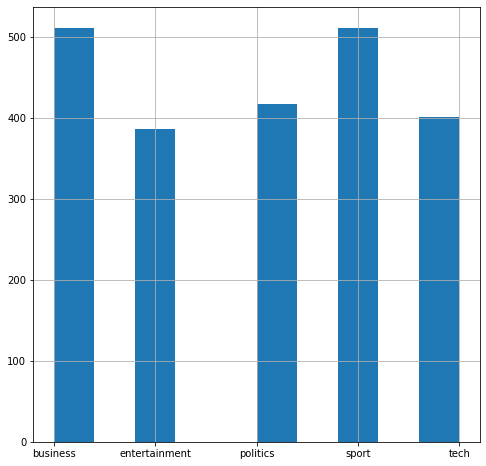

In [153]:
labels.hist(figsize=(8,8))

In [154]:
intrain, intest, ytrain, ytest = train_test_split(inputs, labels, random_state=123 ) 

Score on train data:  0.9922062350119905


100%|██████████| 1000/1000 [00:22<00:00, 44.76it/s]


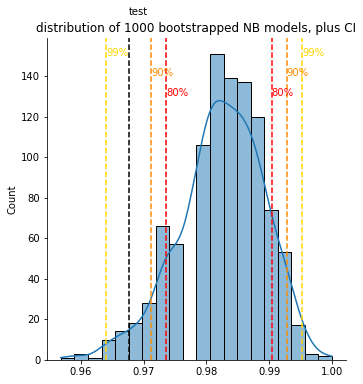

<Figure size 1080x576 with 0 Axes>

In [160]:
CV = Vectorizer()
Xtrain, Xtest = CV(intrain, intest)
m = trained_model(Xtrain,ytrain)
bootstrap('NB',m,Xtrain,ytrain,Xtest,ytest)

Score on train data:  0.9952038369304557


100%|██████████| 1000/1000 [00:34<00:00, 29.10it/s]


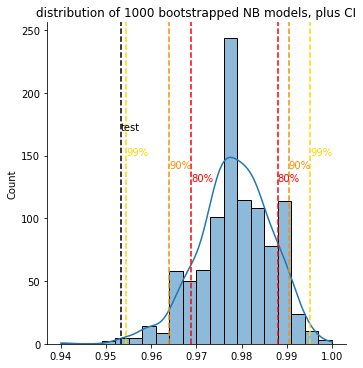

<Figure size 1080x576 with 0 Axes>

In [156]:
CV = Vectorizer(tokenizer=simpleTokenizer())
Xtrain, Xtest = CV(intrain, intest)
m = trained_model(Xtrain,ytrain)
bootstrap('NB',m,Xtrain,ytrain,Xtest,ytest)

Score on train data:  0.9892086330935251


100%|██████████| 1000/1000 [00:19<00:00, 51.16it/s]


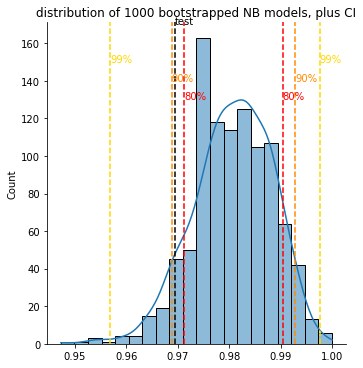

<Figure size 1080x576 with 0 Axes>

In [157]:
CV = Vectorizer(tokenizer=StemTokenizer())
Xtrain, Xtest = CV(intrain, intest)
m = trained_model(Xtrain,ytrain)
bootstrap('NB',m,Xtrain,ytrain,Xtest,ytest)

Score on train data:  0.9922062350119905


100%|██████████| 1000/1000 [00:19<00:00, 51.39it/s]


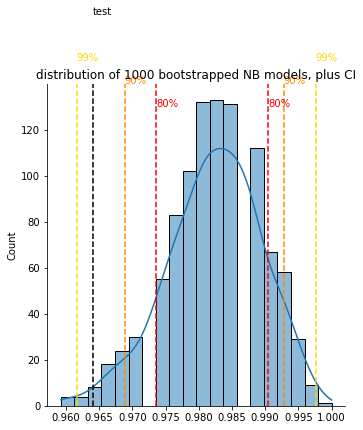

<Figure size 1080x576 with 0 Axes>

In [158]:
CV = Vectorizer(tokenizer=LemmaTokenizer())
Xtrain, Xtest = CV(intrain, intest)
m = trained_model(Xtrain,ytrain)
bootstrap('NB',m,Xtrain,ytrain,Xtest,ytest)

Score on train data:  0.999400479616307


100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s]


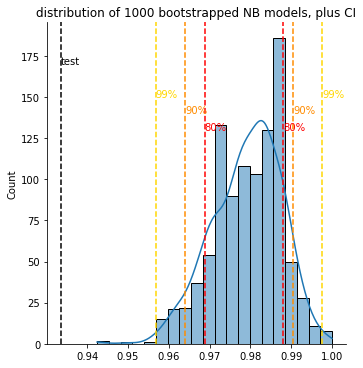

<Figure size 1080x576 with 0 Axes>

In [159]:
CV = Vectorizer(tokenizer=LemmaTokenizer(), token_pattern='[A-Za-z]+', lowercase=True, ngram_range=(1,2))
Xtrain, Xtest = CV(intrain, intest)
m = trained_model(Xtrain,ytrain)
bootstrap('NB',m,Xtrain,ytrain,Xtest,ytest)